---
## FasterRCNN resnet50 for multispectral image (8-channels) with more than 3-channels in input

Modify the FasterRCNN resnet50 model to accept images with 8 input channels, you need to modify the first convolutional layer of the ResNet backbone. 

---


In [1]:
import os
import json 
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm

import torch
from torch.utils.data import Dataset,DataLoader
import torchvision

classes = [_, 'tuta','oidium']  # classes: 0 index is reserved for background
NUM_CLASSES = 3

BATCH_SIZE = 4 # increase / decrease according to GPU memeory
RESIZE_TO = 512 # resize the image for training and transforms

In [2]:
# Function to retrieve GPU info using subprocess
def get_gpu_info():
    try:
        gpu_info = subprocess.check_output(['nvidia-smi'], stderr=subprocess.STDOUT)
        return gpu_info.decode('utf-8')
    except subprocess.CalledProcessError as e:
        return f"Failed to get GPU info: {e.output.decode('utf-8')}"

# Check GPU availability and print the info
gpu_info = get_gpu_info()
if "failed" in gpu_info.lower():
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

# Check if CUDA is available
# Select CPU | GPU use ('cuda' or 'cuda:0')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# Memory info (in bytes)
total_memory, free_memory = torch.cuda.mem_get_info()

# Convert bytes to GB
total_memory_gb = total_memory / (1024**3)  # Convert to GB
free_memory_gb = free_memory / (1024**3)    # Convert to GB

print(f"Total memory: {total_memory_gb:.2f} GB")
print(f"Free memory: {free_memory_gb:.2f} GB")



Mon Sep  1 15:13:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090 Ti   WDDM  |   00000000:2D:00.0  On |                  Off |
|  0%   38C    P8             31W /  450W |    5201MiB /  24564MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Utils


In [3]:
def non_max_suppression(bounding_boxes, confidence_score, threshold):
    """
    Non-max Suppression Algorithm

    @param list  Object candidate bounding boxes
    @param list  Confidence score of bounding boxes
    @param float IoU threshold

    @return Rest boxes after nms operation
    """
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []
    picked = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        #picked_boxes.append(bounding_boxes[index])
        #picked_score.append(confidence_score[index])
        picked.append(index)

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked #picked_boxes, picked_score


## Splited in test and train 

In [5]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

class GenData(Dataset):
    def __init__(self, files_dir, annotation_file, width, height, transformer):
        self.files_dir = files_dir
        self.annotation_file = annotation_file
        self.height = height
        self.width = width
        self.transformer = transformer
        self.imgs = []
        img_ann = []
        imgName_witoutAnn = []

        with open(self.annotation_file) as json_file: 
            data = json.load(json_file) 
            annotations = data["annotations"]
            for ann in annotations:
                img_ann.append(ann['_from_via']['filename'])
        img_name_ann = np.unique(img_ann)
       
        n,a = 0,0
        for image in sorted(list(set(os.listdir(self.files_dir)) - {'desktop.ini', 'whatever.ini'})):
            if image.split('@')[4]=='COLOR_Image.png':
                if image in img_name_ann:
                    self.imgs.append(image)
                    a += 1
                else:
                    n +=1 
                    imgName_witoutAnn.append(image)

    def __getitem__(self, item):
        img_name = self.imgs[item]
        wt, ht = 0,0
        newsize = (self.height, self.width)
        spectral_img = [460, 540, 630, 850, 980] 
        if img_name.split('@')[4] == 'COLOR_Image.png':
            rgb_img_path =  self.files_dir + img_name 
            rgb_img = Image.open(rgb_img_path)
            wt, ht = rgb_img.size
            vis = rgb_img.resize(newsize)
            red, green, blue = vis.split()
            aimg = [red, green, blue]
            for im in spectral_img:
                sp_img =  Image.open(self.files_dir + img_name.replace(img_name.split('@')[4], 'Image_'+str(im)+'.png'))
                sp_img = sp_img.resize(newsize)
                aimg.append(sp_img)

            img_stack = np.dstack(aimg)     
            img = transformer(img_stack)
    

           
        boxes, labels = [], [] 
        with open(self.annotation_file) as json_file: 
            data = json.load(json_file) 
            annotations = data["annotations"]
            for ann in annotations:
                if img_name == ann['_from_via']['filename']:
                    classe = ann['_from_via']['region_attributes']['name']
                    labels.append(classes.index(classe))          
                    cx,cy,w,h =  ann['bbox']  # bounding box
                    cx = (cx/wt)*self.width
                    w = (w/wt)*self.width
                    cy = (cy/ht)*self.height
                    h = (h/ht)*self.height
                    xmin = cx 
                    ymin = cy
                    xmax = cx + w
                    ymax = cy + h
                    boxes.append([xmin, ymin, xmax, ymax])
            if len(boxes) == 0:
                print('Bounding boxes array is empty for img: ', img_name)
       
        bbox = torch.tensor(boxes,dtype=torch.float32)
        label = torch.as_tensor(labels, dtype=torch.int64).reshape(-1,)
        target = {}
        target['boxes'] = bbox
        target['labels'] = label
        return img, target # img, target
    def __len__(self):
        return len(self.imgs)

train_dir = './dataset/TRAIN/'
test_dir = './dataset/TEST/'
annotation_file = './dataset/soup-dataset_whole.json'

dataset_train = GenData(train_dir, annotation_file, 512, 512, transformer) # 512, 512 TRY it!
dataset_test = GenData(test_dir, annotation_file, 512, 512, transformer)# 480, 480

def detection_collate(x):
    return list(tuple(zip(*x)))

dl_train = DataLoader(dataset_train, batch_size=5, shuffle=True, collate_fn=detection_collate)
dl_test = DataLoader(dataset_test , batch_size=5, shuffle=True, collate_fn=detection_collate) 
print('DATASET LEN:', len(dl_train) + len(dl_test), ' split in -> Train:', len(dl_train), ' - Test:', len(dl_test))


DATASET LEN: 46  split in -> Train: 39  - Test: 7


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor

# Modify ResNet to accept 8 input channels
class ResNetWith8Channels(nn.Module):
    def __init__(self, num_channels):
        super(ResNetWith8Channels, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)  # weights=ResNet50_Weights.IMAGENET1K_V1    ResNet50_Weights.DEFAULT 
        #self.resnet = resnet50()
        
        # Modify the first convolution layer to accept 8 input channels
        original_conv1 = self.resnet.conv1
        self.resnet.conv1 = nn.Conv2d(num_channels, original_conv1.out_channels, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Copy the weights from the original conv1 to the new conv1
        with torch.no_grad():
            self.resnet.conv1.weight[:, :3, :, :] = original_conv1.weight
            # Initialize the additional channels with random weights
            nn.init.kaiming_normal_(self.resnet.conv1.weight[:, 3:, :, :])
                 # Replace the rest of the backbone with the modified resnet
        self.layer1 =  self.resnet.layer1
        self.layer2 =  self.resnet.layer2
        self.layer3 =  self.resnet.layer3
        self.layer4 =  self.resnet.layer4

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

# Create the backbone with FPN
def get_resnet_backbone_with_fpn(num_channels):
    backbone = ResNetWith8Channels(num_channels)
    fpn_backbone = _resnet_fpn_extractor(backbone.resnet, trainable_layers=3)

    return fpn_backbone

# Create the Faster R-CNN model
def get_model(num_classes, num_channels):
    backbone = get_resnet_backbone_with_fpn(num_channels)
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )
    image_mean = [0.485] * num_channels  # Mean per 8 canali
    image_std = [0.229] * num_channels  # Std per 8 canali

    # Creare il modello Faster R-CNN con la nuova trasformazione
    model = FasterRCNN(
            backbone,
            num_classes=num_classes,
            #rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler,
            image_mean=image_mean,
            image_std=image_std,
            )
    return model

# Instantiate the model
num_classes = 3  # Including the background
num_channels = 8  # Number of input channels

model = get_model(num_classes, num_channels)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(model)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/admin/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 40.1MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.485, 0.485, 0.485, 0.485, 0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229, 0.229, 0.229, 0.229, 0.229, 0.229])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, e

## Load Model weights for each types of images



In [15]:
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=len(classes))
# Modify the first conv layer to accept 8 channels
conv1 = model.backbone.body.conv1
model.backbone.body.conv1 = torch.nn.Conv2d(
	8, conv1.out_channels, kernel_size=conv1.kernel_size, stride=conv1.stride, padding=conv1.padding, bias=False
)
# Load weights
model.load_state_dict(torch.load('./weights/fasterrcnn_resnet50_DEFAULT_30Ep_5Batch_ALL_IMG_8Channels_6_09_24.pt', map_location=device))
model.to(device)
model.eval()



C:\Users\ThermalX\AppData\Local\Temp\ipykernel_29056\4180577492.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./weights/fasterrcnn_re

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.485, 0.485, 0.485, 0.485, 0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229, 0.229, 0.229, 0.229, 0.229, 0.229])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, e

chanels, w, h =  8 512 512


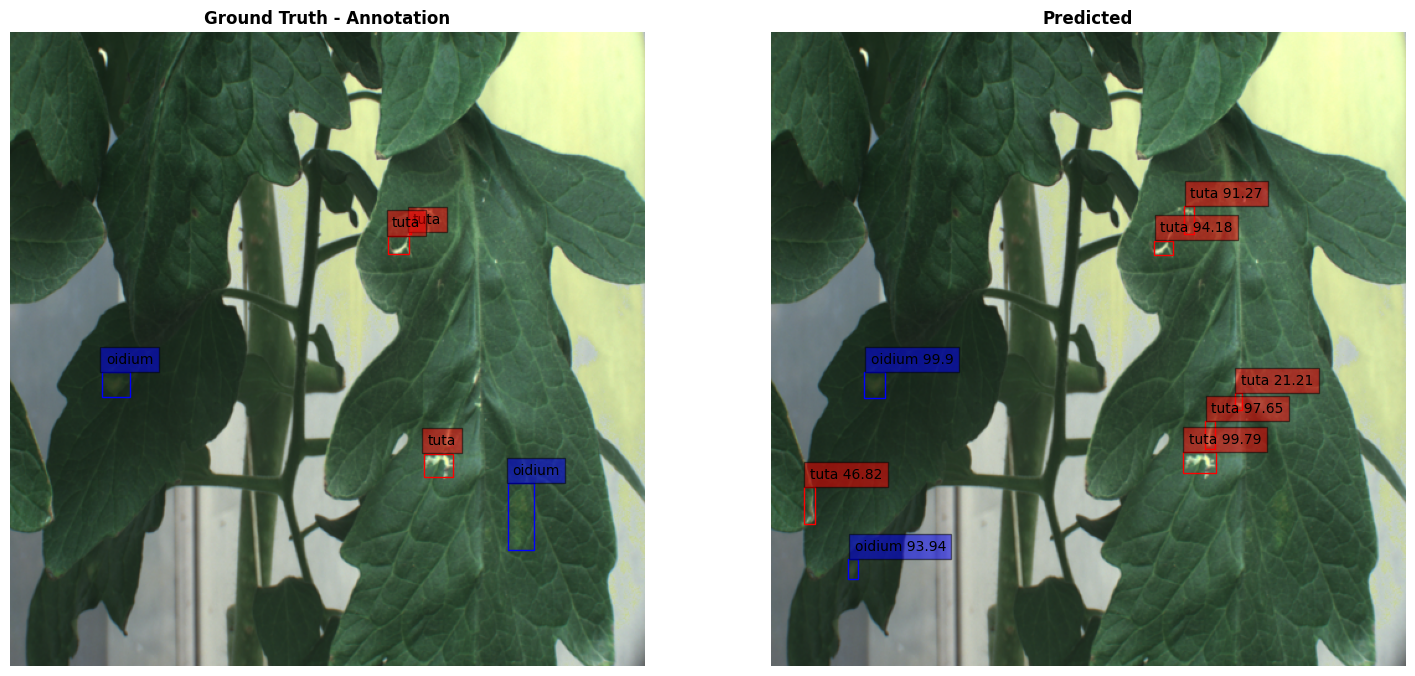

In [19]:
img, label = next(iter(dl_test))
img = img[0].squeeze(0)
chanels,w,h = img.size()  #chanels,w,h = img[0].size()
print('chanels, w, h = ', chanels, w,h)

img_sample = np.transpose(np.array(img[0:3]),(1,2,0))*255
img_sample = img_sample.astype(np.uint8)
img_sample = img_sample.copy()
box1 = label[0]['boxes'].numpy()
label1 = label[0]['labels'].numpy()


fig, axes = plt.subplots(1, 2, figsize=(18, 10)) 
for i in range(len(label1)):
    x1,y1,x2,y2 = int(box1[i][0]),int(box1[i][1]),int(box1[i][2]),int(box1[i][3])
    label = str(classes[label1[i]])
    if label == 'tuta':
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = 'red', facecolor = 'none')
        axes[0].text(x1 + 3, y1 -7, label, bbox=dict(facecolor='red', alpha=0.5))
    else:
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = 'blue', facecolor = 'none')
        axes[0].text(x1 + 3, y1 -7, label, bbox=dict(facecolor='blue', alpha=0.5))
    axes[0].add_patch(rect)  
axes[0].imshow(img_sample)
axes[0].set_title('Ground Truth - Annotation', fontweight ="bold")
axes[0].axis('off')

img=np.transpose(np.array(img),(1,2,0))#*255

img_tensor = torch.from_numpy(img).permute(2,0,1).float().cuda()
out = model(torch.unsqueeze(img_tensor,dim=0))
boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
labels = out[0]['labels'].cpu().detach().numpy()
scores = out[0]['scores'].cpu().detach().numpy()
#print(scores, labels, 'len: ', len(labels))

indexes = non_max_suppression(boxes, scores, 0.01) #0.01

for idx in indexes:
    if scores[idx] >= 0.1:
        x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
        name = classes[labels[idx].item()]
        score = scores[idx]
        #print('Labele', labels[idx].item(), 'Name: ', name, 'Score: ', score)
        if name == 'tuta':
            color = 'red'
        else:
            color = 'blue'
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = color, facecolor = 'none')
        axes[1].text(x1+5, y1-7, name+' '+str(round(score*100,2)), bbox=dict(facecolor=color, alpha=0.5))
        axes[1].add_patch(rect)
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = 'green', facecolor = 'none')
        #axes[0].text(x1+5, y1-7, name+' '+str(round(score*100,2))+' '+model_name, bbox=dict(facecolor=color, alpha=0.5))
        #axes[0].add_patch(rect)
  
axes[1].imshow(img_sample)
axes[1].set_title('Predicted', fontweight ="bold")
axes[1].axis('off')
plt.show()
